## Calculating the RMS of Sea Level Anomaly

The principle here is that the model has absoluate sea level, $\eta$. We also save $\eta^2$. But these are absolute values, not the anomaly from the mean. To calculate the RMS of the Sea Level Anomaly, we want to find

$$R = \left(\overline{(\eta - \overline{\eta})^2}\right)^{1/2}$$
$$ = \left(\overline{\eta^2 - 2 \eta \overline{\eta} + \overline{\eta}^2}\right)^{1/2}$$
$$ = \left(\overline{\eta^2} - 2 \overline{\eta} \overline{\eta} + \overline{\eta}^2\right)^{1/2}$$
$$ = \left(\overline{\eta^2} -  \overline{\eta}^2\right)^{1/2}$$

Thus, we can take the temporal mean of $\eta$ and $eta^2$ to find $R$.

Set `ekey` below to plot different experiments.

In [1]:
%pylab inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from glob import glob
import scipy as sp
import xarray as xr
from xarray.ufuncs import square, sqrt
import pandas as pd
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Populating the interactive namespace from numpy and matplotlib
netcdf_index loaded.
Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

## To deal with memory issues:
* In a terminal on VDI (either over VNC or through SSH and inside screen/tmux), run:
`dask-scheduler`
* This should output the scheduler address, like `tcp://10.0.64.24:8786`. 
* Now, in another terminal (ensuring that the default conda module has cosima_cookbook installed, as all workers will need access to that), run:
`dask-worker tcp://10.0.64.24:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157`
* Then, make sure the following cell matches the scheduler address.

In [3]:
client = Client('tcp://10.0.64.24:8786', local_dir='/local/g40/amh157')
client

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 39409:127.0.0.1:39409 vdi-n24.nci.org.au -l amh157


Client Scheduler: tcp://127.0.0.1:33477 Dashboard: http://127.0.0.1:39409/status,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


In [3]:
%%time
ekey='1deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
sea_level = cc.get_nc_variable(expt,'ocean_month.nc','sea_level',
                               n=n_files,time_units=time_units, offset=offset)\
                               .sel(time=slice(clim_tstart,clim_tend)).mean('time')
    
sea_levelsq = cc.get_nc_variable(expt,'ocean_month.nc','sea_levelsq',
                                 n=n_files,time_units=time_units, offset=offset)\
                                 .sel(time=slice(clim_tstart,clim_tend)).mean('time')
sla_rms_1deg = (sea_levelsq - sea_level**(2.0))**(0.5).load()

In [ ]:
%%time
ekey='025deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
sea_level = cc.get_nc_variable(expt,'ocean_month.nc','sea_level',
                               n=n_files,time_units=time_units, offset=offset)\
                               .sel(time=slice(clim_tstart,clim_tend)).mean('time')
    
sea_levelsq = cc.get_nc_variable(expt,'ocean_month.nc','sea_levelsq',
                                 n=n_files,time_units=time_units, offset=offset)\
                                 .sel(time=slice(clim_tstart,clim_tend)).mean('time')
sla_rms_025deg = (sea_levelsq - sea_level**(2.0))**(0.5).load()

In [ ]:
%%time
ekey='01deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

chunks={'xt_ocean': 400, 'yt_ocean': 300}

# FIX THIS WHEN DATA IS BACK:
n_files = 190
sea_level = cc.get_nc_variable(expt,'ocean_daily.nc','eta_t',
                               n=n_files,time_units=time_units, offset=offset)\
                               .sel(time=slice(clim_tstart,clim_tend)).mean('time')
    
sea_levelsq = cc.get_nc_variable(expt,'ocean_month.nc','sea_levelsq',
                                 n=n_files,time_units=time_units, offset=offset)\
                                 .sel(time=slice(clim_tstart,clim_tend)).mean('time')
sla_rms_01deg = (sea_levelsq - sea_level**(2.0))**(0.5).load()

In [8]:
aviso_file = '/g/data3/hh5/tmp/cosima/observations/original/AVISO_Mean_Std/aviso_ssh_monthly_anom_clim9314_GMSLtrend_removed.timstd.nc'
SLMA = xr.open_dataset(aviso_file).SLMA.mean('TAXM')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139894191896320 and this is thread id 139892366800640.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f3b3685eb90>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139894191896320 and this is thread id 139892366800640.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f3b25e0ac70>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139894191896320 and this is thread id 139892366800640.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f3b24dfc810>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139894191896320 and this is thread id 139892366800640.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f3b0e883810>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

KilledWorker: ("('concatenate-open_dataset-getitem-872e249398b04dbde2d8ce6062f86988', 8363, 3, 0)", 'tcp://127.0.0.1:37664')

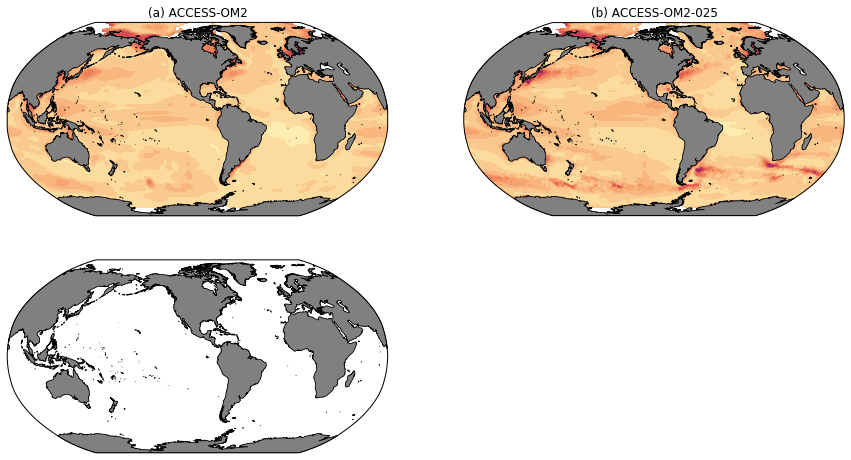

In [4]:
plt.figure(figsize(15,8))
clev = np.arange(0,0.4,0.02)
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',linewidth=0.5)
    

ax = plt.subplot(2,2,1,projection=ccrs.Robinson(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
p1 = sla_rms_1deg.plot.contourf(cmap=cm.cm.matter,levels=clev,add_colorbar=False,
                                extend='max',transform=ccrs.PlateCarree())
plt.title('(a) ACCESS-OM2')

ax = plt.subplot(2,2,2,projection=ccrs.Robinson(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
p1 = sla_rms_025deg.plot.contourf(cmap=cm.cm.matter,levels=clev,add_colorbar=False,
                                extend='max',transform=ccrs.PlateCarree())
plt.title('(b) ACCESS-OM2-025')

ax = plt.subplot(2,2,3,projection=ccrs.Robinson(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
p1 = sla_rms_01deg.plot.contourf(cmap=cm.cm.matter,levels=clev,add_colorbar=False,
                                extend='max',transform=ccrs.PlateCarree())
plt.title('(c) ACCESS-OM2-01')

ax = plt.subplot(2,2,4,projection=ccrs.Robinson(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
p1 = SLMA.plot.contourf(cmap=cm.cm.matter,levels=clev,add_colorbar=False,extend='max',transform=ccrs.PlateCarree())
plt.title('(d) Observations')

ax3 = plt.axes([0.92,0.35,0.01,0.3])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('RMS (m)')
savefigure('sea_level_anomaly_rms')


In [20]:
# testing
SLMA = xr.open_dataset('/g/data3/hh5/tmp/cosima/observations/original/AVISO_Mean_Std/aviso_ssh_monthly_anom_clim9314_GMSLtrend_removed.timstd.nc').SLMA.mean('TAXM')
SLMA

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'SLMA' (LAT: 720, LON: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * LON      (LON) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * LAT      (LAT) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875

Text(0.5, 1.0, 'Observations')

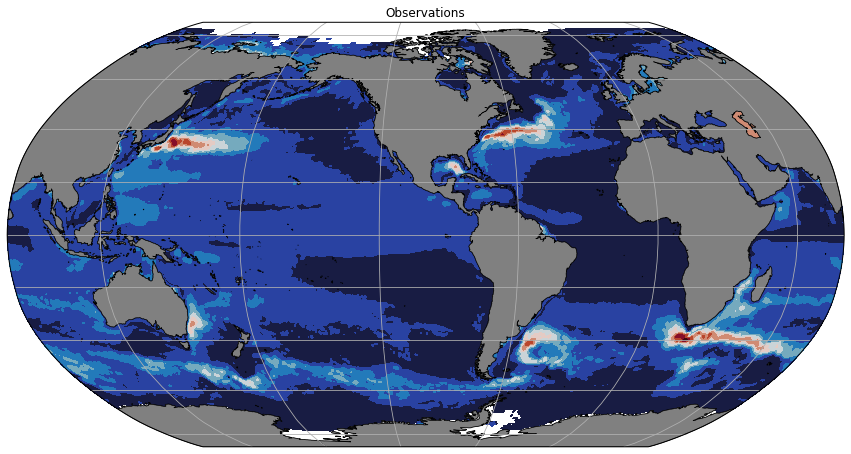

In [12]:
clev = np.arange(0,0.5,0.05)
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',linewidth=0.5)

ax1 = plt.subplot(1,1,1,projection=ccrs.Robinson(central_longitude=-100))
ax1.coastlines(resolution='50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels=False)
p1 = SLMA.plot.contourf(cmap=cm.cm.balance,levels=clev,add_colorbar=False,transform=ccrs.PlateCarree())
#p1 = sla_rms.plot.contourf(cmap=cm.cm.balance,levels=clev,add_colorbar=False,transform=ccrs.PlateCarree())
plt.title('Observations')